## 9.5. Machine Translation and the Dataset

In [26]:
import os
from mxnet import np, npx
from d2l import mxnet as d2l

npx.set_np()

In [27]:
# 9.5.1. Downloading and Preproccessing the Dataset
d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip', '94646ad1522d915e7b0f9296181140edcf86a4f5')

In [28]:
def read_data_nmt():
    """Load the English-French dataset."""
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r', encoding='utf-8') as f:
        return f.read()

In [29]:
raw_text = read_data_nmt()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



In [30]:
def preprocess_nmt(text):
    """Preprocess the English-French dataset."""
    no_space = lambda char, prev_char: char in set(',.!?') and prev_char != ' '
    # Replace non-breaking space with space, and convert uppercase letters to lowercase ones
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # Insert space between words and punctuation marks
    out = [
        ' ' + char if i > 0 and no_space(char, text[i - 1]) else char
        for i, char in enumerate(text)
    ]
    return ''.join(out)

In [31]:
text = preprocess_nmt(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


In [32]:
# 9.5.2. Tokenization
# 对长句子进行分词
def tokenize_nmt(text, num_examples=None):
    """Tokenize the English-French dataset."""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

In [35]:
source, target = tokenize_nmt(text)
'source',len(source), source[:6], 'target',len(target), target[:6]

('source',
 167130,
 [['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 'target',
 167130,
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

167130 167130


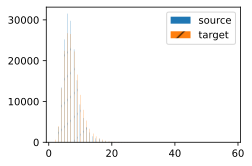

In [10]:
d2l.set_figsize()
source_len = [len(l) for l in source]
target_len = [len(l) for l in target]
_, _, patches = d2l.plt.hist([source_len, target_len], bins=300, label=['source', 'target'])
for patch in patches[1].patches:
    patch.set_hatch('/')
d2l.plt.legend(loc='upper right')
print(len(source_len), len(target_len))

In [17]:
# 9.5.3. Vocabulary
# 建立单词词典
src_vocab = d2l.Vocab(source, min_freq=2, reserved_tokens=['<pad>', '<bos>', 'eos>'])
len(src_vocab),src_vocab.token_freqs[0:10]

(10012,
 [('.', 139392),
  ('i', 45611),
  ('you', 43192),
  ('to', 36718),
  ('the', 33263),
  ('?', 27619),
  ('a', 23973),
  ('is', 16829),
  ('tom', 13990),
  ('that', 12651)])

In [18]:
# 9.5.4. Loading the Dataset
# 将不定长的句子进行截断或者填充使之固定长度方便进行小批量加载
def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences."""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncate
    return line + [padding_token] * (num_steps - len(line))  # Pad

In [21]:
source[0],truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

(['go', '.'], [47, 4, 1, 1, 1, 1, 1, 1, 1, 1])

In [40]:
source[3000],truncate_pad(src_vocab[source[3000]], 10, src_vocab['<pad>'])

(['whose', 'is', 'it', '?'], [848, 11, 17, 9, 1, 1, 1, 1, 1, 1])

In [41]:
def build_array_nmt(lines, vocab, num_steps):
    """Transform text sequences of machine translation into minibatcches."""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = np.array([truncate_pad(l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).astype(np.int32).sum(1)
    return array, valid_len

In [42]:
# 9.5.5. Putting All Things Together
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """Return the iterator and vocabularies of the translation dataset."""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

In [43]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print("X:", X.astype(np.int32))
    print("valid lengths for X:", X_valid_len)
    print("Y:", Y.astype(np.int32))
    print("valid lengths for Y:", Y_valid_len)
    break

X: [[14 27  4  3  1  1  1  1]
 [ 7  0  4  3  1  1  1  1]]
valid lengths for X: [4 4]
Y: [[ 26 118   5   3   1   1   1   1]
 [  6   7   0   4   3   1   1   1]]
valid lengths for Y: [4 5]


### 9.5.6. Summary
1.  机器翻译是指将序列从一种语言自动翻译为另一种语言
2.  基于单词级别进行分词的词汇量远远大于基于字符级别进行分词的词汇量。将不常见的分词使用同一个未知标签进行标注
3.  通过截断或者填充方式处理文本序列，使得所有加载的文本序列都具有相同的长度方便小批量加载。